## Analyzing A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This is my project done for the Udacity Data Analyst nanodegree. It is an A/B test simulating data from an e-commerce website. My goal is to find out if the company should implement a new page design or keep the old one. 


<a id='probability'></a>
#### Part I - Probability


In [40]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [41]:
df = pd.read_csv('ab_data.csv')

In [42]:
len(df)

294478

In [43]:
df.user_id.nunique()

290584

The proportion of users converted.

In [44]:
(df.query('converted==True').nunique() / df.user_id.nunique()).user_id

0.12104245244060237

The number of times the `new_page` and `treatment` don't match.

In [45]:
len(df.query('landing_page == "new_page" & group != "treatment" | landing_page != "new_page" & group == "treatment"'))

3893

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page

In [47]:
df2 = df.query('landing_page == "old_page" & group == "control" | landing_page == "new_page" & group == "treatment"')

In [48]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [49]:
df2.shape

(290585, 5)

In [50]:
assert(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0] == 0)

In [51]:
df2.user_id.nunique()

290584

Repeated user_ids?

In [52]:
(df2.user_id.value_counts()>1)

773192     True
630732    False
811737    False
797392    False
795345    False
801490    False
799443    False
787157    False
793302    False
817882    False
842446    False
815835    False
805596    False
803549    False
809694    False
807647    False
895712    False
840399    False
836301    False
899810    False
834242    False
936604    False
934557    False
940702    False
938655    False
830144    False
828097    False
832195    False
838348    False
821956    False
          ...  
734668    False
736717    False
730574    False
775632    False
771538    False
642451    False
773587    False
783828    False
785877    False
779734    False
781783    False
759256    False
726472    False
748999    False
746950    False
753093    False
751044    False
740803    False
738754    False
744897    False
742848    False
634271    False
632222    False
636316    False
630169    False
650647    False
648598    False
654741    False
652692    False
630836    False
Name: user_id, Length: 2

What is the row information for the repeat **user_id**? 

In [53]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [54]:
df2 = df2.drop(1899)
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


What is the probability of an individual converting regardless of the page they receive?

In [55]:
sum(df2.converted==1) / len(df2.converted)

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [56]:
df2[(df2['converted']==1) & (df2['group']== 'control') ].shape[0]/ (df2[df2['group']=='control'].shape[0])


0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [57]:
df2[(df2['converted']==1) & (df2['group']== 'treatment') ].shape[0]/ (df2[df2['group']=='treatment'].shape[0])

0.11880806551510564

What is the probability that an individual received the new page?

In [58]:
df2[(df2['landing_page']=='new_page')].shape[0]/ df2.shape[0]

0.5000619442226688

- All of the probabilities calculated in the a-d steps above are almost the same
- This concludes that there is not enough evidence to conclude that new treatment page leads to ore conversions

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should my null and alternative hypotheses be?

- H0 : **$p_{old}$** - **$p_{new}$** >= 0
- H1 : **$p_{old}$** - **$p_{new}$** < 0

`2.` I will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will also use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

**Conversion rate** for $p_{new}$ under the null

In [59]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**Conversion rate** for $p_{old}$ under the null

In [60]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group

In [61]:
n_new = df2.query('group == "treatment"').user_id.nunique()
n_new

145310

$n_{old}$, the number of individuals in the control group

In [62]:
n_old = df2.query('group == "control"').user_id.nunique()
n_old

145274

Simulating of $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null

In [63]:
new_page_converted = np.random.choice([1,0], size = n_new, p = (p_new, 1-p_new))

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null

In [64]:
old_page_converted = np.random.choice([1,0], size = n_old, p = (p_old, 1-p_old))

$p_{new}$ - $p_{old}$ for our simulated values

In [65]:
new_page_converted.mean() - old_page_converted.mean()

-0.0018952486734795382

10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used earlier

In [66]:
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.choice([1,0], size = n_old, p = (p_old, 1-p_old))
    new_page_converted = np.random.choice([1,0], size = n_new, p = (p_new, 1-p_new))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

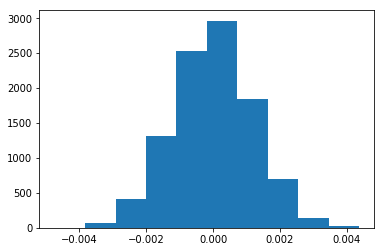

In [67]:
plt.hist(p_diffs);

Proportion of the **p_diffs**  greater than the actual difference observed in **ab_data.csv**

In [68]:
p_old = df2.query("group == 'control'").converted.mean()
p_new = df2.query("group == 'treatment'").converted.mean()
p_new - p_old

-0.0015782389853555567

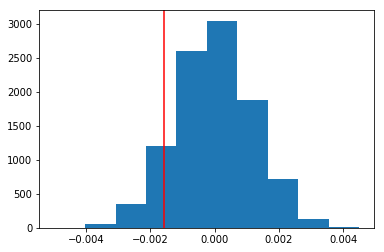

In [69]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.axvline(p_new - p_old, color = 'r')
plt.hist(null_vals);


In [70]:
(null_vals > (p_new - p_old)).mean()

0.90490000000000004

I calculated the <b>P-value</b> at 0.9018. This value means the probability of observing our statistic from the null hypothesis. I was also given Type I error rate of 5% and P-value > alpha. This leads us to the data which shows that with this error rate the old page has higher probability of conversion (than the new page)

In [71]:
import statsmodels.api as sm
from scipy.stats import norm


convert_old = df2.query('landing_page == "old_page" & converted==1').user_id.nunique()
convert_new = df2.query('landing_page == "new_page" & converted==1').user_id.nunique()

n_old = df2.query('landing_page == "old_page"').user_id.nunique()
n_new = df2.query('landing_page == "new_page"').user_id.nunique()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [72]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_old, convert_new]), np.array([n_old, n_new]), alternative='smaller')

In [73]:
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [74]:
#z_critical
norm.ppf(1-(0.05))

1.6448536269514722

The P-value came out as 0.905 which almost matches the one I have calculated previously. The Z-score of 1.31092 does not exceed the z_critical of 1.6448 suggesting that I have failed to reject the null hypothesis based on the Z-test. All of this agrees to our previous findings.

<a id='regression'></a>
### Part III - A regression approach

In [75]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [76]:
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('drop', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [79]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
results = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [80]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:26:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with <b>ab_page</b> is 0.1899. <br>It differs for the simple reason that we are now discussing a different hypothesis than before. Our null hypothesis -  ab_page = 1, converted = 0. 
<br>The alternative hypothesis is that when ab_page = 1, converted is more likely to be 1.

### <b>Factors to consider</b>

There are many different factors that could play their part here. It is a good idea to find and add them because it will help us making a better model and evaluate our hypothesis better but it might disadvantageous it by possibly adding a problem of multicollinearility. 

### Does it appear that country had an impact on conversion?

In [ ]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

In [ ]:
countries_df.country.value_counts()

In [ ]:
countries_df[['CA', 'UK', 'US']] = pd.get_dummies(countries_df['country'])
countries_df.head()

In [ ]:
final_df = df2.merge(countries_df, on='user_id', how='inner')
final_df.head()

In [ ]:
results = sm.Logit(final_df['converted'], final_df[['intercept', 'ab_page', 'CA', 'UK']]).fit()
results.summary()

It seems like that country does not have a big impact on conversion based on the p-values in this summary.

In [ ]:
final_df['treatment_UK'] = final_df['UK']*final_df['ab_page']
final_df['treatment_CA'] = final_df['CA']*final_df['ab_page']
final_df['treatment_US'] = final_df['US']*final_df['ab_page']
final_df.head()

In [ ]:
results = sm.Logit(final_df['converted'], final_df[['intercept', 'treatment_CA', 'treatment_UK','treatment_US']]).fit()
results.summary()

Here we can see one particular p-value as statistically significant - the p-value of treatment_CA is 0.030 which is below 0.05

## Conclusion

In conclusion, I first aimed to find out if the landing page influenced the conversion rate for the possible reason of updating the landing page. Our null hypothesis was therefore that the old landing page has the same or even higher converted rate than the new page, our alternative that the new page has a higher conversion rate. 
I used an A/B test to draw my conclusions. I found out that there is a small amount of statistical significance in Canada user conversion but this does not hold much practical significance, since ab_page and country of origin were insignificant. Ultimately, this means that there is no real reason to suggest switching to the new page, since we did not prove that it would increase the user conversion rate.

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0